<ipython-input-1-a93c68c78d17>:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['handset_type'].fillna(df['handset_type'].mode()[0], inplace=True)



Data after cleaning: 106965 rows remaining

Top 10 tcp_dl_retrans values:
       MSISDN/Number  avg_rtt_dl  avg_rtt_ul  avg_throughput_dl  \
85790   3.369858e+10       244.0       242.0            26456.0   
32276   3.365871e+10        62.0        19.0            80994.0   
58029   3.366491e+10       305.0       148.0            52901.0   
31945   3.365863e+10        61.0        27.0            87516.0   
62052   3.366613e+10       178.0        30.0            57104.0   
70082   3.366877e+10       149.0        23.0            70272.0   
43632   3.366131e+10        35.0        46.0            94139.0   
48344   3.366240e+10        42.0        22.0            61286.0   
64116   3.366682e+10        93.0        64.0            35609.0   
98217   3.376264e+10        50.0        18.0            45244.0   

       avg_throughput_ul  tcp_dl_retrans  tcp_ul_retrans      handset_type  
85790             5310.0    4.289488e+09      11989838.0  Huawei B528S-23A  
32276            13188.0    4.288

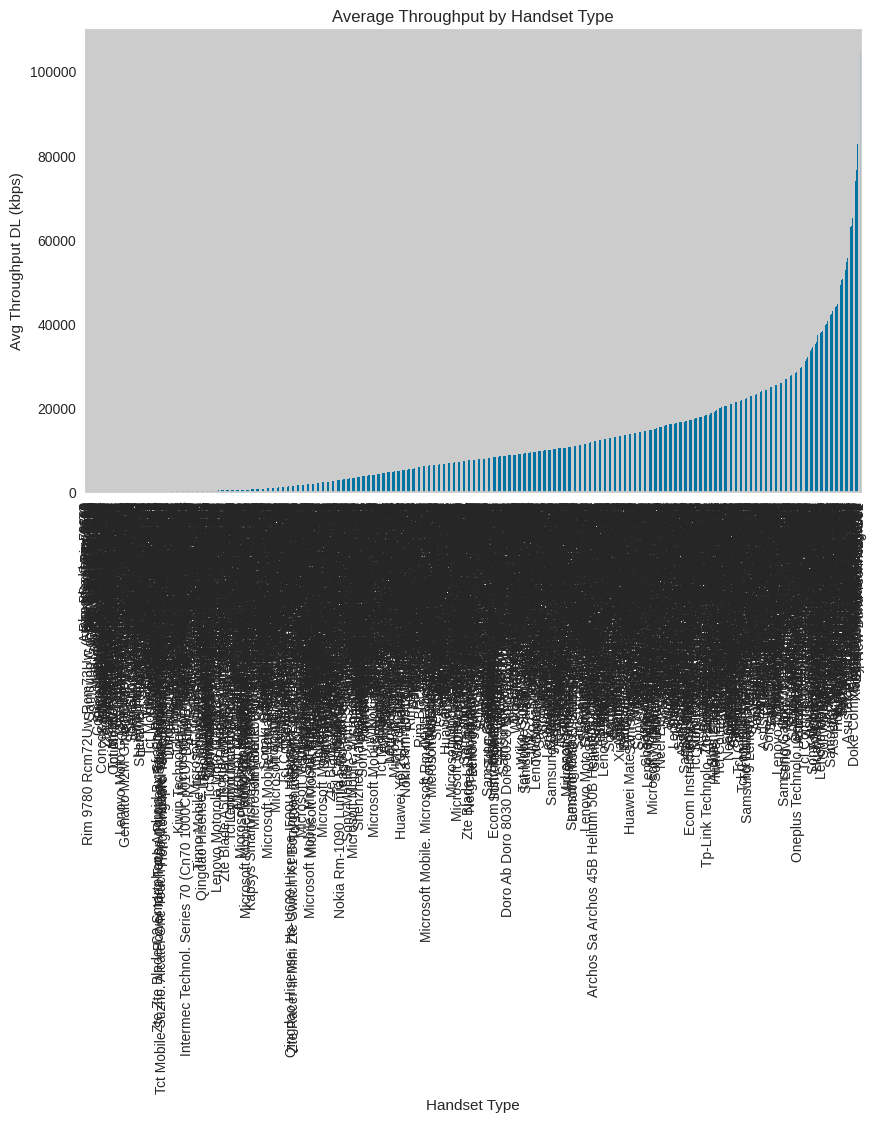

handset_type
Archos Sa Core 70 3G                0.000000
Rim Blackberry 9860                 0.000000
Rim 8520                            0.000000
Rim Pearl 8100                      0.000000
Samsung Gt-I9105                    0.000000
                                   ...      
Spa Condor Elect. Allure M2     83294.500000
Huawei B715S-23C                90316.916667
Huawei Y9 2019                  90557.000000
Lg G6+                          97747.000000
New-Bund Technol. Mix 2        104669.000000
Name: avg_throughput_dl, Length: 1396, dtype: float64


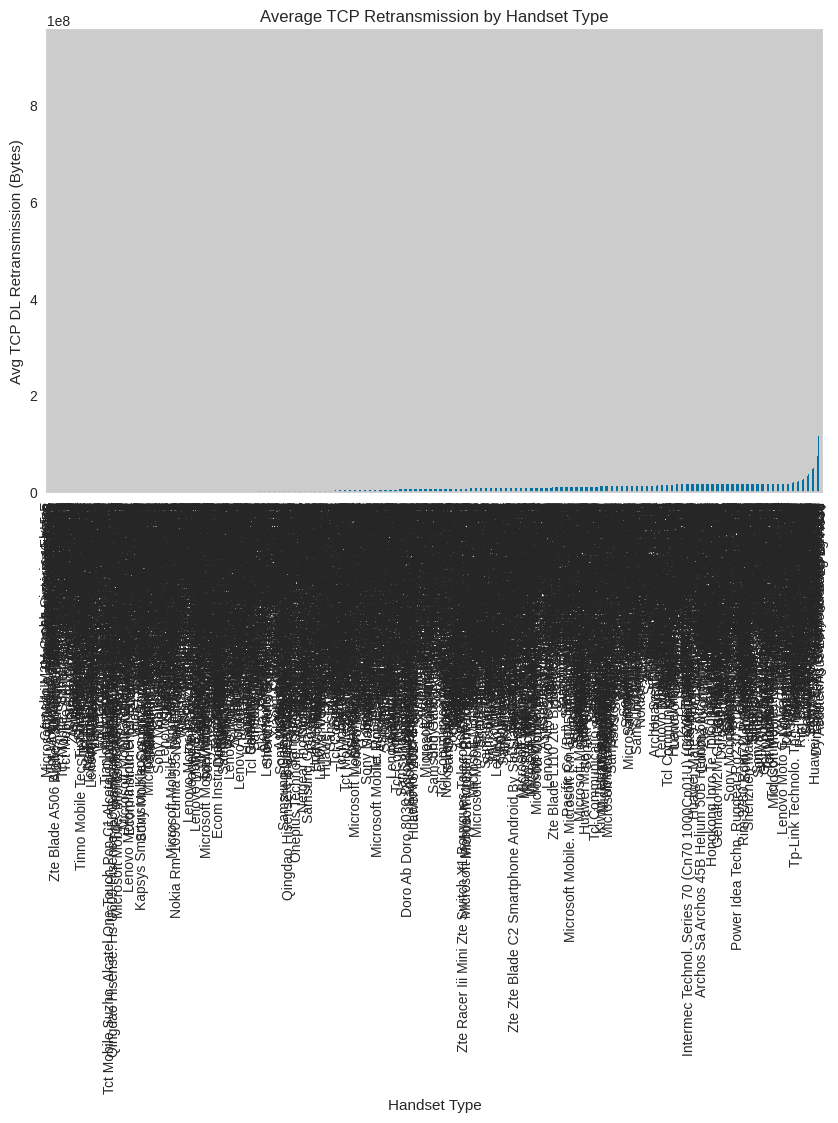

handset_type
Gemalto M2M Gmbh Cinterion Ehs5-E             1.200000e+01
Microsoft Mobile. Rm-1062 Lumia 640 Xl Lte    4.500000e+01
Hmd Global Oy Nokia 6 Ds                      5.700000e+01
Archos Sa Sense 55S                           6.600000e+01
Tcl Communicatio. Nura 2                      7.500000e+01
                                                  ...     
Samsung Galaxy Tab S3 (Sm-T825)               1.268012e+08
Huawei E5776S-32                              2.016799e+08
Asustek Asus Zenfone Selfie Zd551Kl           3.189534e+08
Huawei Bln-Al10                               3.290646e+08
Lg Lg-H635                                    9.104622e+08
Name: tcp_dl_retrans, Length: 1396, dtype: float64


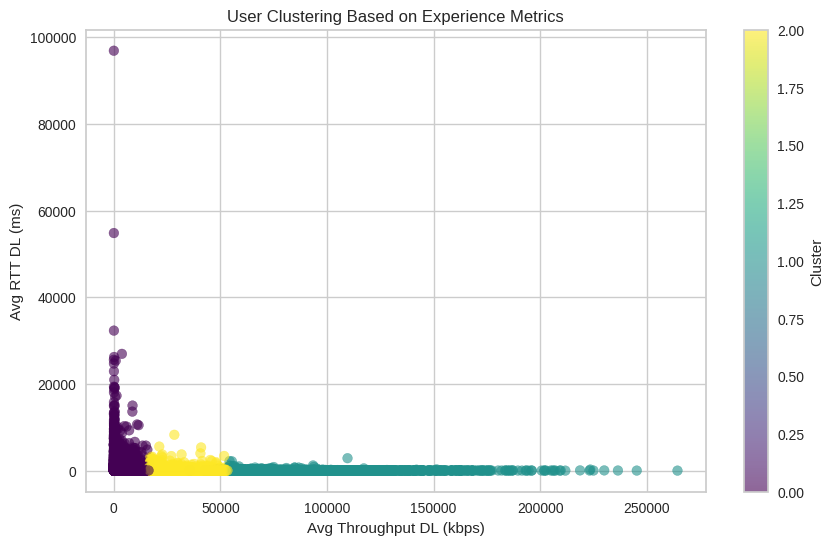

In [ ]:
from db_connection import fetch_data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer

# SQL Query to Aggregate User Experience Metrics
QUERY_EXPERIENCE = """
SELECT "MSISDN/Number",
       AVG("Avg RTT DL (ms)") AS avg_rtt_dl,
       AVG("Avg RTT UL (ms)") AS avg_rtt_ul,
       AVG("Avg Bearer TP DL (kbps)") AS avg_throughput_dl,
       AVG("Avg Bearer TP UL (kbps)") AS avg_throughput_ul,
       AVG("TCP DL Retrans. Vol (Bytes)") AS tcp_dl_retrans,
       AVG("TCP UL Retrans. Vol (Bytes)") AS tcp_ul_retrans,
       "Handset Type" AS handset_type
FROM xdr_data
GROUP BY "MSISDN/Number", "Handset Type"
"""

# Fetch Data
def load_experience_data():
    return fetch_data(QUERY_EXPERIENCE)

# Data Cleaning (Task 3.1)
def clean_experience_data(df):
    df.fillna(df.mean(numeric_only=True), inplace=True)
    df['handset_type'].fillna(df['handset_type'].mode()[0], inplace=True)
    print(f"\nData after cleaning: {len(df)} rows remaining")
    return df

# Compute Top/Bottom/Frequent Metrics (Task 3.2)
def compute_top_bottom_frequent(df, column, top_n=10):
    print(f"\nTop {top_n} {column} values:")
    print(df.nlargest(top_n, column))
    
    print(f"\nBottom {top_n} {column} values:")
    print(df.nsmallest(top_n, column))
    
    print(f"\nMost frequent {column} values:")
    print(df[column].value_counts().head(top_n))

# Distribution by Handset Type (Task 3.3)
def analyze_throughput_by_handset(df):
    distribution = df.groupby('handset_type')['avg_throughput_dl'].mean().sort_values()
    distribution.plot(kind='bar', figsize=(10, 6))
    plt.title('Average Throughput by Handset Type')
    plt.xlabel('Handset Type')
    plt.ylabel('Avg Throughput DL (kbps)')
    plt.show()
    print(distribution)

def analyze_tcp_by_handset(df):
    tcp_view = df.groupby('handset_type')['tcp_dl_retrans'].mean().sort_values()
    tcp_view.plot(kind='bar', figsize=(10, 6))
    plt.title('Average TCP Retransmission by Handset Type')
    plt.xlabel('Handset Type')
    plt.ylabel('Avg TCP DL Retransmission (Bytes)')
    plt.show()
    print(tcp_view)

# Normalize Data for Clustering (Task 3.4)
def normalize_data(df):
    scaler = MinMaxScaler()
    scaled_features = scaler.fit_transform(df[['avg_rtt_dl', 'avg_throughput_dl', 'tcp_dl_retrans']])
    return scaled_features

# Perform K-means Clustering (Task 3.4)
def perform_clustering(df, scaled_data, k=3):
    kmeans = KMeans(n_clusters=k, random_state=42)
    df['cluster'] = kmeans.fit_predict(scaled_data)
    return df

# Visualize Clusters
def visualize_clusters(df):
    plt.figure(figsize=(10, 6))
    plt.scatter(df['avg_throughput_dl'], df['avg_rtt_dl'], c=df['cluster'], cmap='viridis', alpha=0.6)
    plt.title('User Clustering Based on Experience Metrics')
    plt.xlabel('Avg Throughput DL (kbps)')
    plt.ylabel('Avg RTT DL (ms)')
    plt.colorbar(label='Cluster')
    plt.show()

if __name__ == "__main__":
    # Load Data
    experience_data = load_experience_data()

    # Clean Data (Task 3.1)
    experience_data_cleaned = clean_experience_data(experience_data)

    # Compute Top/Bottom/Frequent Values (Task 3.2)
    compute_top_bottom_frequent(experience_data_cleaned, 'tcp_dl_retrans')
    compute_top_bottom_frequent(experience_data_cleaned, 'avg_rtt_dl')
    compute_top_bottom_frequent(experience_data_cleaned, 'avg_throughput_dl')

    # Distribution Analysis (Task 3.3)
    analyze_throughput_by_handset(experience_data_cleaned)
    analyze_tcp_by_handset(experience_data_cleaned)

    # Normalize Data
    normalized_data = normalize_data(experience_data_cleaned)

    # Perform Clustering (Task 3.4)
    clustered_data = perform_clustering(experience_data_cleaned, normalized_data)

    # Visualize Clusters
    visualize_clusters(clustered_data)